In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import random
import torch.backends.cudnn as cudnn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.linalg import norm

NUM_CLASSES = 2
SEED = 5636
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
cudnn.benchmark = True

def get_balanced_data(dataset, num_samples=None):

    if num_samples is None:
        num_samples = len(dataset)

    # Make balanced classes
    labelset = {}
    for i in range(NUM_CLASSES):
        one_hot = torch.zeros(NUM_CLASSES)
        one_hot[i] = 1
        labelset[i] = one_hot

    # All attributes found in list_attr_celeba.txt
    feature_idx = 31  # Index of feature label - 15 corresponds to glasses, 31 is smiling
    by_class = {}
    features = []
    for idx in tqdm(range(len(dataset))):
        if idx > 10000:
            break
        ex, label = dataset[idx]
        features.append(label[feature_idx])
        g = label[feature_idx].numpy().item()
        ex = ex.flatten()
        ex = ex / norm(ex)
        if g in by_class:
            by_class[g].append((ex, labelset[g]))
        else:
            by_class[g] = [(ex, labelset[g])]
        if idx > num_samples:
            break
    data = []
    max_len = min(25000, len(by_class[1]))

    data.extend(by_class[1][:max_len])
    data.extend(by_class[0][:max_len])
    return data

def split(trainset, p=.8):
    train, val = train_test_split(trainset, train_size=p)
    return train, val


SIZE = 64
transform = transforms.Compose(
    [transforms.Resize([SIZE,SIZE]),
     transforms.ToTensor()
    ])

celeba_path = 'datasets/'
trainset = torchvision.datasets.CelebA(root=celeba_path,
                                       split='train',
                                       transform=transform,
                                       download=True)

trainset = get_balanced_data(trainset)
trainset, valset = split(trainset, p=.8)

print("Train Size: ", len(trainset), "Val Size: ", len(valset))

Files already downloaded and verified


  6%|███▉                                                            | 10001/162770 [00:06<01:41, 1511.12it/s]

Train Size:  7715 Val Size:  1929


In [2]:
testset = torchvision.datasets.CelebA(root=celeba_path,
                                      split='test',
                                      transform=transform,
                                      download=True)

testset = get_balanced_data(testset)
print("Test Size: ", len(testset))

Files already downloaded and verified


 50%|████████████████████████████████▌                                | 10001/19962 [00:06<00:06, 1520.01it/s]

Test Size:  10001


In [3]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(valset, batch_size=100,
                                        shuffle=False, num_workers=1)

test_loader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=1)

def get_data(loader):
    X = []
    y = []
    for idx, batch in enumerate(loader):
        inputs, labels = batch
        X.append(inputs)
        y.append(labels)
    return torch.cat(X, dim=0).numpy(), torch.cat(y, dim=0).numpy()

X_train, y_train = get_data(train_loader)
X_val, y_val = get_data(val_loader)
X_test, y_test = get_data(test_loader)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7715, 12288) (7715, 2)
(1929, 12288) (1929, 2)
(10001, 12288) (10001, 2)


In [4]:
import rfm  
from tqdm import tqdm 

model = rfm.RFM()
model = model.fit(X_train[:2000], y_train[:2000], num_iters=1, reg=0, 
                  centering=True, verbose=True, diag_only=True)

Starting Iteration: 0
Solved Kernel Regression in 7.963541030883789 seconds.
Computed Gradients in 24.5413498878479 seconds.


100%|█████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1282.65it/s]

(12288, 12288)
Computed EGOP in 0.09964108467102051 seconds.


Solved Final Kernel Regression in 8.019516229629517 seconds.


(64, 64, 3)


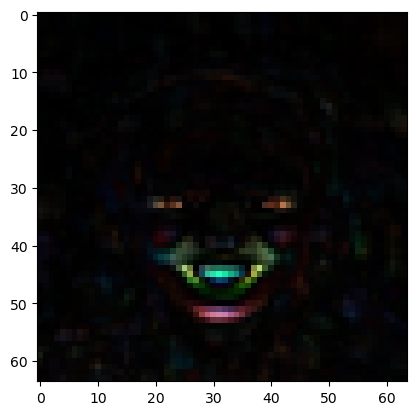

In [6]:
import matplotlib.pyplot as plt

M = model.get_M()
diag = np.diag(M).reshape(3, 64, 64)
diag = np.rollaxis(diag, 0, 3)
diag = (diag - diag.min()) / (diag.max() - diag.min())
print(diag.shape)
plt.imshow(diag)
plt.show()